In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
import torch
import torch.nn as nn
import os, os.path as osp
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [4]:
import imageio
import skimage.io, skimage.transform, skimage.color

In [5]:
import alpine

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/home/kv30/KV/ALL_INR_PROJECTS/ALPINE_LIBRARY/alpine/alpine/trainers/base.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [6]:
nlcd_file = "./data/nlcd/nlcd_2021.tif"

In [7]:
def nlcd_to_integer_index(nlcd_arr):
    nlcd_temp_contrib = {
            11: 0,   # Open Water
            12: 1,  # Perennial Ice/Snow

            21: 2,   # Developed, Open Space
            22: 3,  # Developed, Low Intensity
            23: 4,   # Developed, Medium Intensity
            24: 5,   # Developed, High Intensity

            31: 6,  # Barren Land

            41: 7,   # Deciduous Forest
            42: 8,  # Evergreen Forest
            43: 9,  # Mixed Forest

            51: 10,   # Dwarf Scrub
            52: 11,   # Shrub/Scrub

            71: 12,  # Grassland/Herbaceous
            72: 13,  # Sedge/Herbaceous
            73: 14,   # Lichens
            74: 15,  # Moss

            81: 16,   # Pasture/Hay
            82: 17,   # Cultivated Crops

            90: 18,   # Woody Wetlands
            95: 19   # Emergent Herbaceous Wetlands
        }
    nlcd_keys = list(nlcd_temp_contrib.keys())
    nlcd_temp_contrib_arr = np.zeros((100), dtype=np.float32)
    for k, v in nlcd_temp_contrib.items():
        nlcd_temp_contrib_arr[k] = v

    nlcd_updated = nlcd_temp_contrib_arr[nlcd_arr]
    return nlcd_updated

In [8]:
data = imageio.v3.imread(nlcd_file)
data = nlcd_to_integer_index(data)
k = 0.2
data = cv2.resize(data, (int(data.shape[1]*k), int(data.shape[0]*k)), interpolation=cv2.INTER_NEAREST)[...,np.newaxis]
print(data.shape)

H,W = data.shape[:2]

<tifffile.TiffPage 0 @8> parsing GDAL_NODATA tag raised ValueError("invalid literal for int() with base 10: '0.0'")


(384, 516, 1)


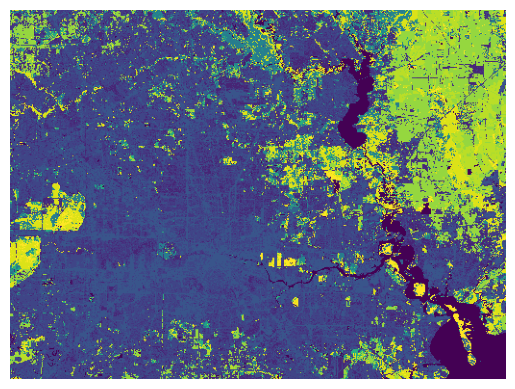

In [9]:
plt.figure()
plt.imshow(data)
plt.axis('off')
# plt.savefig("./output/nlcd/nlcd_input.pdf", bbox_inches='tight', pad_inches=0, dpi=200)
plt.show()

In [10]:
NUM_CLASSES = 20

In [11]:
inr_categorical = alpine.models.Wire(
    in_features = 2,
    out_features = NUM_CLASSES,
    hidden_features = 256,
    hidden_layers = 6).float().cuda()

In [12]:
class CategoricalLoss(nn.Module):
    def __init___(self):
        super(CategoricalLoss, self).__init__()
    
    def forward(self, pred, target):
        # print(pred['output'].shape, target['signal'].shape)
        x = pred['output'].permute(0, 3, 1, 2)
        y = target['signal'].permute(0, 3, 1, 2).squeeze(1).long()
        # print(x.shape, y.shape)
        loss = nn.functional.cross_entropy(x, y, reduction='mean')
        return loss

In [13]:
inr_categorical.register_loss_function(CategoricalLoss().float().cuda())

In [14]:
inr_categorical.compile()

In [15]:
coords = alpine.utils.get_coords_spatial(H, W)[None,...].float().cuda()
print(coords.shape)

torch.Size([1, 384, 516, 2])


In [16]:
gt_tensor = torch.from_numpy(data)[None,...].float().cuda()
print(gt_tensor.shape)

torch.Size([1, 384, 516, 1])


In [17]:
fit_nlcd = inr_categorical.fit_signal(
    input = coords,
    signal = gt_tensor,
    n_iters = 10000
)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [18]:
torch.save({'weights':inr_categorical.state_dict(), 'gt':gt_tensor}, "./output/nlcd/inr_categorical.pt")

In [20]:
def remap_nlcd(x):
    mapping = {0:[80,107,158],
               1: [234,241,252],
               2 : [222,206,206],
               3: [210,155,133],
               4 : [227,49,34],
               5: [157, 31, 21],
               6: [178, 175, 168],
               7 : [123, 169, 110],
               8 :[51, 100, 56],
               9: [192, 203, 153],
               10: [171, 150, 75],
               11: [205, 188, 137],
               12: [237, 236, 207],
               13 : [208,209,139],
               14 : [172, 203, 98],
               15 : [141,185,159],
               16 : [220, 216, 92],
               17 : [165, 117, 55],
               18: [191, 213, 235],
               19 : [123, 163, 189],}

    xmap = np.zeros((x.shape[0], x.shape[1], 3), dtype=np.uint8)
    for _x in np.unique(x):
        rows, cols = np.where(x == _x)
        xmap[rows, cols, :] = np.array(mapping[_x])
    
    return xmap
    

In [24]:
print(data.shape)

(384, 516, 1)


In [28]:
data_remap = remap_nlcd(data.squeeze())
output_nlcd = torch.softmax(fit_nlcd['output'], dim=-1).argmax(-1).cpu().detach().numpy()[0]
output_nlcd_remap = remap_nlcd(output_nlcd)
print(data_remap.shape, output_nlcd_remap.shape)

(384, 516, 3) (384, 516, 3)


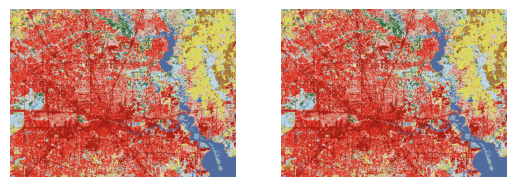

In [30]:
plt.figure()
plt.subplot(121)
plt.imshow(data_remap)
plt.axis('off')
plt.subplot(122)
plt.imshow(output_nlcd_remap)
plt.axis('off')
plt.savefig("./output/nlcd/nlcd_output.pdf", bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()
